</center> Clbesch_FlowField</center>

# 数据

## 读取原始数据

In [2]:
import scipy.io as sio
import torch


In [58]:

# 读取速度场数据
velocity_data = sio.loadmat('D:/zjPhD/Programzj/psiToU/Ginzburg_Lan/Clebsch_flowfield/data/High_Resolution/train/velocity_field.mat')
ux0 = torch.tensor(velocity_data['ux'], dtype=torch.float32)
uy0 = torch.tensor(velocity_data['uy'], dtype=torch.float32)

# 读取波函数数据
wave_function_data = sio.loadmat('D:/zjPhD/Programzj/psiToU/Ginzburg_Lan/Clebsch_flowfield/data/High_Resolution/train/wave_function.mat')
psi1_0 = torch.tensor(wave_function_data['psi1'], dtype=torch.complex64)
psi2_0 = torch.tensor(wave_function_data['psi2'], dtype=torch.complex64)

# 读取误差场数据
error_field_data = sio.loadmat('D:/zjPhD/Programzj/psiToU/Ginzburg_Lan/Clebsch_flowfield/data/High_Resolution/train/error_field.mat')
vx_error0 = torch.tensor(error_field_data['vx_error'], dtype=torch.float32)
vy_error0 = torch.tensor(error_field_data['vy_error'], dtype=torch.float32)

# 打印数据形状以确认
print(f'ux shape: {ux0.shape}')
print(f'uy shape: {uy0.shape}')
print(f'psi1 shape: {psi1_0.shape}')
print(f'psi2 shape: {psi2_0.shape}')
print(f'vx_error shape: {vx_error0.shape}')
print(f'vy_error shape: {vy_error0.shape}')


ux shape: torch.Size([512, 512])
uy shape: torch.Size([512, 512])
psi1 shape: torch.Size([512, 512])
psi2 shape: torch.Size([512, 512])
vx_error shape: torch.Size([512, 512])
vy_error shape: torch.Size([512, 512])


In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


# 常用函数


In [95]:
# 归一化函数
def normalize(tensor):
    return (tensor - tensor.mean()) / tensor.std()


import numpy as np

def normalize_np(array):
    return (array - np.mean(array)) / np.std(array)



In [15]:
import numpy as np

class VelocityFieldCalculator:
    def __init__(self, resx, resy, hbar, Npsi):
        self.resx = resx
        self.resy = resy
        self.hbar = hbar
        self.Npsi = Npsi

        # ix 和 iy 可以是用于索引的网格
        self.ix, self.iy = np.meshgrid(np.arange(resx), np.arange(resy), indexing='ij')
        self.ixp = (self.ix + 1) % resx  # 对应 MATLAB 中的 mod(ix, resx) + 1
        self.iyp = (self.iy + 1) % resy  # 对应 MATLAB 中的 mod(iy, resy) + 1

    def VelocityOneForm(self, psi):
        thetax = np.zeros((self.resx, self.resy), dtype=np.complex64)
        thetay = np.zeros((self.resx, self.resy), dtype=np.complex64)

        for ii in range(self.Npsi):
            # 这里要确保 psi[self.ixp, :, ii] 的结果形状与 thetax 匹配
            thetax += np.conj(psi[:, :, ii]) * psi[self.ixp[:,0], :, ii]
            thetay += np.conj(psi[:, :, ii]) * psi[:, self.iyp[0,:], ii]

        vx = self.hbar * np.angle(thetax)
        vy = self.hbar * np.angle(thetay)

        return vx, vy


In [16]:
# 示例使用方法
resx, resy = 512, 512  # 示例分辨率
hbar = 1.0  # 这里假设 hbar = 1
Npsi = 2  # 假设有两个波函数

psi = np.random.rand(resx, resy, Npsi) + 1j * np.random.rand(resx, resy, Npsi)
psi.shape

(512, 512, 2)

In [19]:
velocity_calculator = VelocityFieldCalculator(resx, resy, hbar, Npsi)


psi1_np = psi1_0.numpy()
psi2_np = psi2_0.numpy()

psi_combined = np.stack((psi1_np, psi2_np), axis=-1)  # 组合成 (resx, resy, 2)

vx, vy = velocity_calculator.VelocityOneForm(psi_combined)



# 模型

## 预测误差

In [ ]:
import torch 
import torch.nn as nn


In [ ]:
class ErrorPredictCNN(nn.Module):
    def __init__(self):
        super(ErrorPredictCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()  

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()


    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = self.conv4(x)

        return x

In [ ]:
model  = ErrorPredictCNN().to(device)

In [60]:
ux = ux0.clone()
uy = uy0.clone()
psi1 = psi1_0.clone()
psi2 = psi2_0.clone()

psi1_real  = torch.real(psi1)
psi1_imag  = torch.imag(psi1)
psi2_real  = torch.real(psi2)
psi2_imag  = torch.imag(psi2)


vx_error = vx_error0.clone()
vy_error = vy_error0.clone()



print(f'ux shape: {ux.shape}')
print(f'uy shape: {uy.shape}')
print(f'psi1 shape: {psi1.shape}')
print(f'psi2 shape: {psi2.shape}')
print(f'psi1_real shape: {psi1_real.shape}')
print(f'psi1_imag shape: {psi1_imag.shape}')
print(f'psi2_real shape: {psi2_real.shape}')
print(f'psi2_imag shape: {psi2_imag.shape}')

print(f'vx_error shape: {vx_error.shape}')
print(f'vy_error shape: {vy_error.shape}')



ux shape: torch.Size([512, 512])
uy shape: torch.Size([512, 512])
psi1 shape: torch.Size([512, 512])
psi2 shape: torch.Size([512, 512])
psi1_real shape: torch.Size([512, 512])
psi1_imag shape: torch.Size([512, 512])
psi2_real shape: torch.Size([512, 512])
psi2_imag shape: torch.Size([512, 512])
vx_error shape: torch.Size([512, 512])
vy_error shape: torch.Size([512, 512])


In [61]:
# 读取和归一化数据
ux = normalize(ux0.clone().unsqueeze(0).unsqueeze(0)).to(device)
uy = normalize(uy0.clone().unsqueeze(0).unsqueeze(0)).to(device)
psi1 = psi1_0.clone().unsqueeze(0).unsqueeze(0).to(device)
psi2 = psi2_0.clone().unsqueeze(0).unsqueeze(0).to(device)

# 将复数数据拆分为实部和虚部，并进行归一化
psi1_real = normalize(torch.real(psi1)).to(device)
psi1_imag = normalize(torch.imag(psi1)).to(device)
psi2_real = normalize(torch.real(psi2)).to(device)
psi2_imag = normalize(torch.imag(psi2)).to(device)

# 错误数据不需要归一化，因为它们是训练目标
vx_error = vx_error0.clone().unsqueeze(0).unsqueeze(0).to(device)
vy_error = vy_error0.clone().unsqueeze(0).unsqueeze(0).to(device)

# 打印数据形状
print(f'ux shape: {ux.shape}')
print(f'uy shape: {uy.shape}')
print(f'psi1_real shape: {psi1_real.shape}')
print(f'psi1_imag shape: {psi1_imag.shape}')
print(f'psi2_real shape: {psi2_real.shape}')
print(f'psi2_imag shape: {psi2_imag.shape}')

print(f'vx_error shape: {vx_error.shape}')
print(f'vy_error shape: {vy_error.shape}')

ux shape: torch.Size([1, 1, 512, 512])
uy shape: torch.Size([1, 1, 512, 512])
psi1_real shape: torch.Size([1, 1, 512, 512])
psi1_imag shape: torch.Size([1, 1, 512, 512])
psi2_real shape: torch.Size([1, 1, 512, 512])
psi2_imag shape: torch.Size([1, 1, 512, 512])
vx_error shape: torch.Size([1, 1, 512, 512])
vy_error shape: torch.Size([1, 1, 512, 512])


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(psi1_real.squeeze().cpu().numpy())

In [71]:
psi1_pred = psi1_real.squeeze().cpu().numpy() + 1j * psi1_imag.squeeze().cpu().numpy()
psi2_pred = psi2_real.squeeze().cpu().numpy() + 1j * psi2_imag.squeeze().cpu().numpy()


psi_combined = np.stack((psi1_pred, psi2_pred), axis=-1)

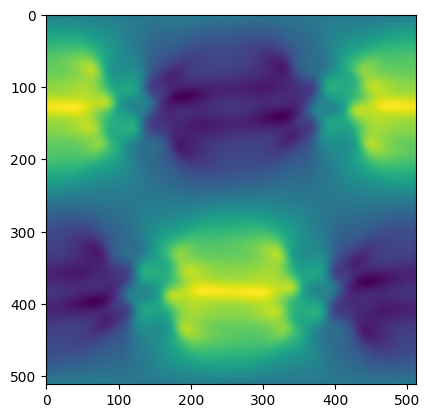

In [72]:
velocity_calculator = VelocityFieldCalculator(resx, resy, hbar, Npsi)
vx, vy = velocity_calculator.VelocityOneForm(psi_combined)

plt.imshow(vx)

In [ ]:
input_data = torch.cat((ux, uy, psi1_real, psi1_imag, psi2_real, psi2_imag), dim=1)

input_data.shape

In [ ]:
# 目标输出合并为2个通道
target_error = torch.cat((vx_error, vy_error), dim=1)

print(f'target_error shape: {target_error.shape}')

In [ ]:
# 损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# 训练循环
num_epochs = 100000  # 设定你想要的训练轮数
for epoch in range(num_epochs):
    # 清零梯度
    optimizer.zero_grad()
    
    # 前向传播
    predicted_error = model(input_data)
    
    # 计算损失
    loss = 100000*criterion(predicted_error, target_error)
    
    # 反向传播
    loss.backward()
    
    # 更新参数
    optimizer.step()
    
    # 打印每个 epoch 的损失
    if (epoch + 1) % 10 == 0:  # 每10个 epoch 打印一次
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


In [ ]:
# 可视化结果（在 GPU 上训练，但绘图在 CPU 上）
predicted_error_cpu = predicted_error.detach().cpu().numpy()
vx_error_cpu = vx_error.detach().cpu().numpy()



In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.imshow(vx_error_cpu[0,0,:,:],vmin=-0.006,vmax=0.004)
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(predicted_error_cpu[0,0,:,:],vmin=-0.006,vmax=0.004)
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(predicted_error_cpu[0,0,:,:] - vx_error_cpu[0,0,:,:],vmin=-0.006,vmax=0.004)
plt.colorbar()

plt.show()

## 超分辨

### 波函数超分辨

#### 下采样数据

In [21]:
import scipy.io as sio
import torch


In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.io as sio

# 读取数据
velocity_data = sio.loadmat('D:/zjPhD/Programzj/psiToU/Ginzburg_Lan/Clebsch_flowfield/data/High_Resolution/train/velocity_field.mat')
ux0 = torch.tensor(velocity_data['ux'], dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1, 1, 512, 512)
uy0 = torch.tensor(velocity_data['uy'], dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1, 1, 512, 512)

wave_function_data = sio.loadmat('D:/zjPhD/Programzj/psiToU/Ginzburg_Lan/Clebsch_flowfield/data/High_Resolution/train/wave_function.mat')
psi1_0 = torch.tensor(wave_function_data['psi1'], dtype=torch.complex64)
psi2_0 = torch.tensor(wave_function_data['psi2'], dtype=torch.complex64)

# 分别提取实部和虚部，并添加通道维度
psi1_real = psi1_0.real.unsqueeze(0).unsqueeze(0)  # (1, 1, 512, 512)
psi1_imag = psi1_0.imag.unsqueeze(0).unsqueeze(0)  # (1, 1, 512, 512)
psi2_real = psi2_0.real.unsqueeze(0).unsqueeze(0)  # (1, 1, 512, 512)
psi2_imag = psi2_0.imag.unsqueeze(0).unsqueeze(0)  # (1, 1, 512, 512)

print(f'ux0 shape: {ux0.shape}')
print(f'uy0 shape: {uy0.shape}')
print(f'psi1_real shape: {psi1_real.shape}')
print(f'psi1_imag shape: {psi1_imag.shape}')
print(f'psi2_real shape: {psi2_real.shape}')
print(f'psi2_imag shape: {psi2_imag.shape}')


ux0 shape: torch.Size([1, 1, 512, 512])
uy0 shape: torch.Size([1, 1, 512, 512])
psi1_real shape: torch.Size([1, 1, 512, 512])
psi1_imag shape: torch.Size([1, 1, 512, 512])
psi2_real shape: torch.Size([1, 1, 512, 512])
psi2_imag shape: torch.Size([1, 1, 512, 512])


#### 划分验证集

In [24]:
# 生成验证集
def split_data(tensor, val_ratio=0.2):
    train_size = int((1 - val_ratio) * tensor.shape[-1])-1
    train_tensor, val_tensor = torch.split(tensor, [train_size, tensor.shape[-1] - train_size], dim=-1)
    return train_tensor, val_tensor


In [25]:
# 分割训练集和验证集
ux0_train, ux0_val = split_data(ux0)
uy0_train, uy0_val = split_data(uy0)
psi1_real_train, psi1_real_val = split_data(psi1_real)
psi1_imag_train, psi1_imag_val = split_data(psi1_imag)
psi2_real_train, psi2_real_val = split_data(psi2_real)
psi2_imag_train, psi2_imag_val = split_data(psi2_imag)

print(f'ux_train shape: {ux0_train.shape}')
print(f'ux_val shape: {ux0_val.shape}')
print(f'psi1_real_train shape: {psi1_real_train.shape}')
print(f'psi1_real_val shape: {psi1_real_val.shape}')
print(f'psi2_imag_train shape: {psi2_imag_train.shape}')
print(f'psi2_imag_val shape: {psi2_imag_val.shape}')


ux_train shape: torch.Size([1, 1, 512, 408])
ux_val shape: torch.Size([1, 1, 512, 104])
psi1_real_train shape: torch.Size([1, 1, 512, 408])
psi1_real_val shape: torch.Size([1, 1, 512, 104])
psi2_imag_train shape: torch.Size([1, 1, 512, 408])
psi2_imag_val shape: torch.Size([1, 1, 512, 104])


#### 定义模型

In [26]:
# 模型定义
class SuperResolutionCNN(nn.Module):
    def __init__(self):
        super(SuperResolutionCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        # 上采样（从128x128到256x256）
        self.upconv1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.relu4 = nn.ReLU()

        # 上采样（从256x256到512x512）
        self.upconv2 = nn.ConvTranspose2d(in_channels=64, out_channels=2, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))

        x = self.relu4(self.upconv1(x))  # 第一次上采样
        x = self.upconv2(x)  # 第二次上采样

        return x


In [27]:
# 归一化函数
def normalize(tensor):
    return (tensor - tensor.mean()) / tensor.std()

# 下采样函数
def downsample(ux, uy, psi1_real, psi1_imag, psi2_real, psi2_imag):
    downsample = nn.AvgPool2d(kernel_size=4, stride=4)
    ux_low_res = downsample(ux)
    uy_low_res = downsample(uy)
    psi1_real_low_res = downsample(psi1_real)
    psi1_imag_low_res = downsample(psi1_imag)
    psi2_real_low_res = downsample(psi2_real)
    psi2_imag_low_res = downsample(psi2_imag)
    low_res_input = torch.cat([ psi1_real_low_res, psi1_imag_low_res], dim=1)
    return low_res_input

# 数据预处理
low_res_input_train = downsample(ux0_train, uy0_train, psi1_real_train, psi1_imag_train, psi2_real_train, psi2_imag_train)
low_res_input_val = downsample(ux0_val, uy0_val, psi1_real_val, psi1_imag_val, psi2_real_val, psi2_imag_val)

low_res_input_train.shape, low_res_input_val.shape


(torch.Size([1, 2, 128, 102]), torch.Size([1, 2, 128, 26]))

#### 模型初始及训练

In [28]:
# 模型初始化
model = SuperResolutionCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)


In [29]:
# 训练循环
model.train()
epochs = 20000

for epoch in range(epochs):
    optimizer.zero_grad()

    # 将输入传递给模型
    output_train = model(low_res_input_train.to(device))

    # 计算损失
    target_train  = torch.cat([psi1_real_train, psi1_imag_train], dim=1).to(device)  # 目标是高分辨率的 ux 和 uy
    loss_train = 10000*criterion(output_train, target_train)

    # 反向传播和优化
    loss_train.backward()
    optimizer.step()


    model.eval()
    with torch.no_grad():
        output_val = model(low_res_input_val.to(device))
        target_val = torch.cat([psi1_real_val, psi1_imag_val], dim=1).to(device)
        loss_val = criterion(output_val, target_val)


    model.train() 
    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {loss_train.item()}, Validation Loss: {loss_val.item()}')




Epoch 1/20000, Training Loss: 2239.4931640625, Validation Loss: 0.21052712202072144
Epoch 2/20000, Training Loss: 2237.5302734375, Validation Loss: 0.21034736931324005
Epoch 3/20000, Training Loss: 2235.575439453125, Validation Loss: 0.2101675420999527
Epoch 4/20000, Training Loss: 2233.6181640625, Validation Loss: 0.2099875807762146
Epoch 5/20000, Training Loss: 2231.644775390625, Validation Loss: 0.2098071426153183
Epoch 6/20000, Training Loss: 2229.67236328125, Validation Loss: 0.20962686836719513
Epoch 7/20000, Training Loss: 2227.69873046875, Validation Loss: 0.2094457447528839
Epoch 8/20000, Training Loss: 2225.70263671875, Validation Loss: 0.20926381647586823
Epoch 9/20000, Training Loss: 2223.701904296875, Validation Loss: 0.20908120274543762
Epoch 10/20000, Training Loss: 2221.694091796875, Validation Loss: 0.20889773964881897
Epoch 11/20000, Training Loss: 2219.666259765625, Validation Loss: 0.2087128758430481
Epoch 12/20000, Training Loss: 2217.62890625, Validation Loss: 0.2

#### 可视化结果及误差

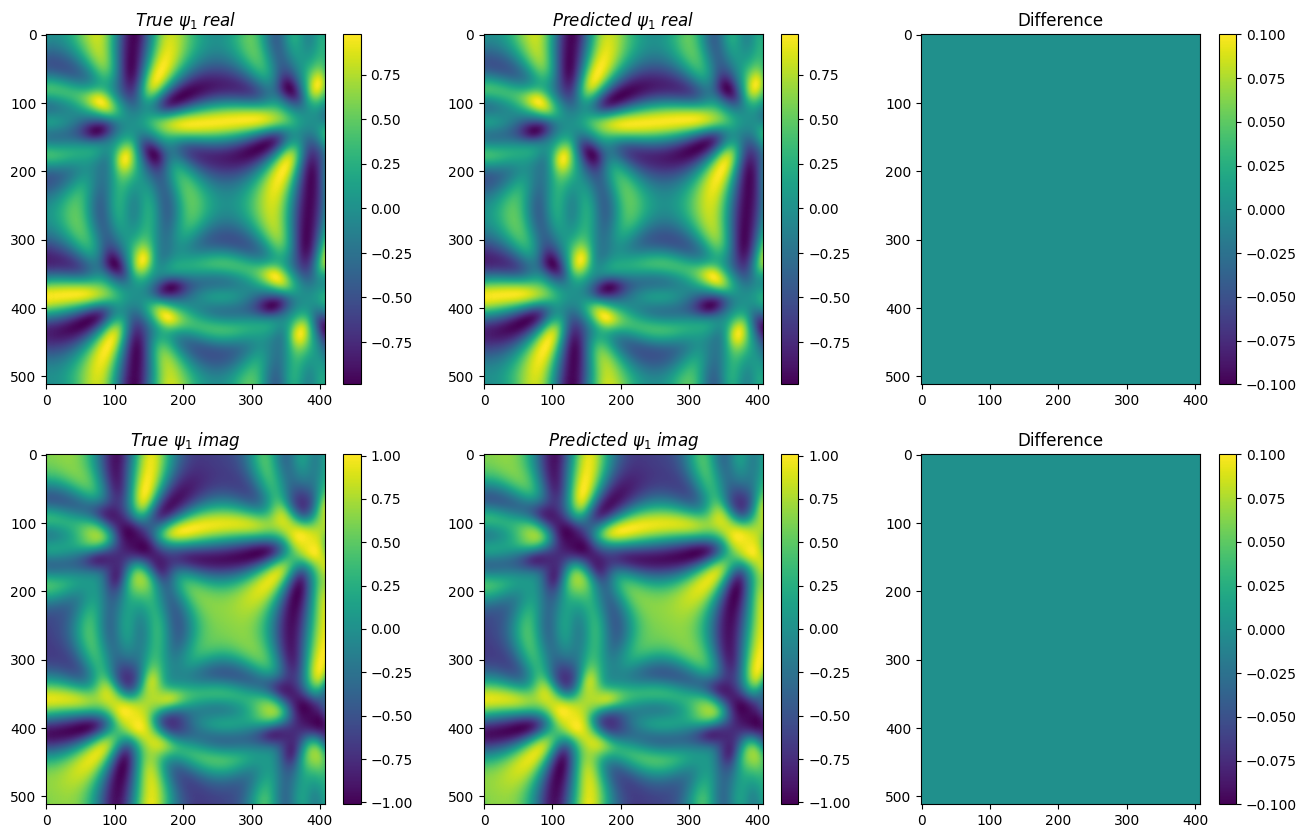

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,10))
plt.subplot(2,3,1)
plt.imshow(output_train[0,0,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('$True\ \psi_1\ real$')


plt.subplot(2,3,2)
plt.imshow(output_train[0,0,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('$Predicted\ \psi_1\ real$')

plt.subplot(2,3,3)
plt.imshow(output_train[0,0,:,:].detach().cpu().numpy() - output_train[0,0,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('Difference')

plt.subplot(2,3,4)
plt.imshow(output_train[0,1,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('$True\ \psi_1\ imag$')

plt.subplot(2,3,5)
plt.imshow(output_train[0,1,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('$Predicted\ \psi_1\ imag$')

plt.subplot(2,3,6)
plt.imshow(output_train[0,1,:,:].detach().cpu().numpy() - output_train[0,1,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('Difference')

plt.show()


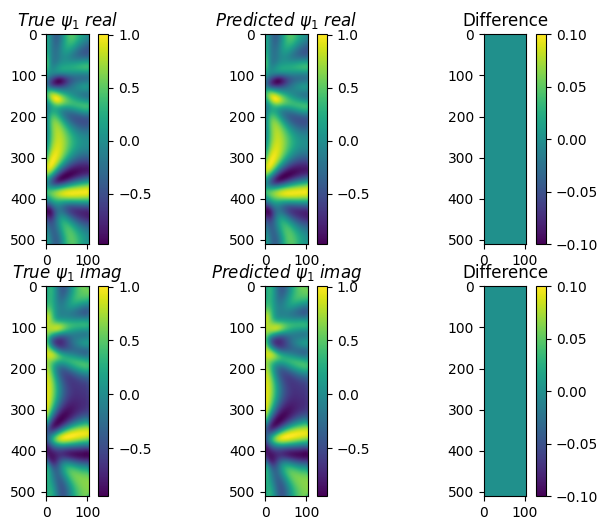

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.subplot(2,3,1)
plt.imshow(output_val[0,0,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('$True\ \psi_1\ real$')

plt.subplot(2,3,2)
plt.imshow(output_val[0,0,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('$Predicted\ \psi_1\ real$')

plt.subplot(2,3,3)
plt.imshow(output_val[0,0,:,:].detach().cpu().numpy() - output_val[0,0,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('Difference')

plt.subplot(2,3,4)
plt.imshow(output_val[0,1,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('$True\ \psi_1\ imag$')

plt.subplot(2,3,5)
plt.imshow(output_val[0,1,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('$Predicted\ \psi_1\ imag$')

plt.subplot(2,3,6)
plt.imshow(output_val[0,1,:,:].detach().cpu().numpy() - output_val[0,1,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('Difference')

plt.show()


In [32]:
output_train[0,1,:,:].detach().cpu().numpy().shape, output_val[0,1,:,:].detach().cpu().numpy().shape

((512, 408), (512, 104))

In [33]:
import numpy as np
output_train_img_part = output_train[0, 1, :, :].detach().cpu().numpy()
output_val_img_part = output_val[0, 1, :, :].detach().cpu().numpy()

output_train_real_part = output_train[0, 0, :, :].detach().cpu().numpy()
output_val_real_part = output_val[0, 0, :, :].detach().cpu().numpy()


output_psi1_img = np.concatenate((output_train_img_part, output_val_img_part), axis=1)
output_psi1_real = np.concatenate((output_train_real_part, output_val_real_part), axis=1)


output_psi1_img.shape, output_psi1_real.shape

((512, 512), (512, 512))

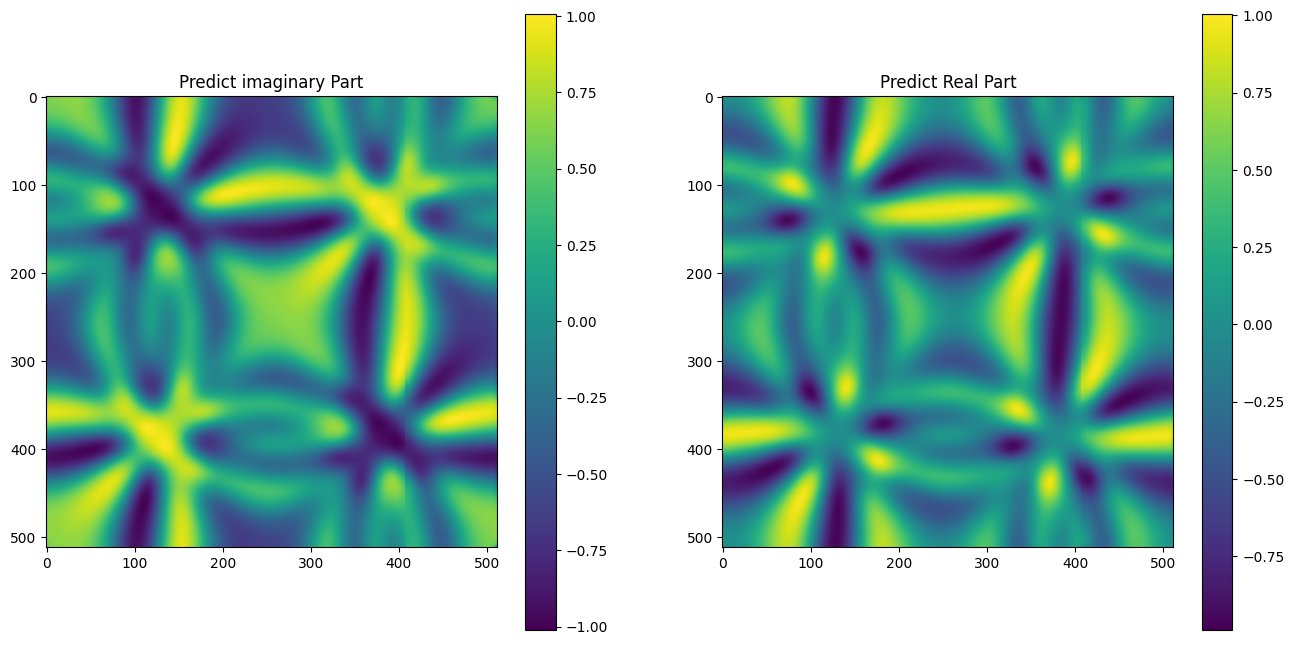

In [34]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(output_psi1_img)
plt.colorbar()
plt.title('Predict imaginary Part')

plt.subplot(1,2,2)
plt.imshow(output_psi1_real)
plt.colorbar()
plt.title('Predict Real Part')

plt.show()

In [35]:

psi1_real_pre = output_train[0,0,:,:].detach().cpu().numpy().copy()
psi1_imag_pre = output_train[0,1,:,:].detach().cpu().numpy().copy()

psi1_tra_real = target_train[0,0,:,:].detach().cpu().numpy()
psi1_tar_imag = target_train[0,1,:,:].detach().cpu().numpy()

error = np.sum((psi1_tra_real - psi1_real_pre) ** 2 + (psi1_tar_imag - psi1_imag_pre) ** 2)

# 计算实际值的平方和（用来归一化误差）
total_energy = np.sum(psi1_tra_real ** 2 + psi1_tar_imag ** 2)

# 计算相对误差
relative_error = error / total_energy

# 打印结果
print(f'相对误差: {relative_error}')

相对误差: 7.160026143537834e-05


#### 上述模型用$\psi_1$进行的训练和验证

psi_Net 使用的输入是两个通道的，即分别是$\psi_1$的实部，以及$\psi_1$的虚部

接下来，将使用$\psi_2$进行测试

In [36]:
psi2_real = psi2_0.real.unsqueeze(0).unsqueeze(0)  # (1, 1, 512, 512)
psi2_imag = psi2_0.imag.unsqueeze(0).unsqueeze(0)  # (1, 1, 512, 512)


psi2_real.shape, psi2_imag.shape

(torch.Size([1, 1, 512, 512]), torch.Size([1, 1, 512, 512]))

In [37]:
test_input = torch.cat([psi2_real, psi2_imag], dim=1)

test_input.shape

torch.Size([1, 2, 512, 512])

In [38]:
def downsample_psi2(ux, uy, psi1_real, psi1_imag, psi2_real, psi2_imag):
    downsample = nn.AvgPool2d(kernel_size=4, stride=4)
    ux_low_res = downsample(ux)
    uy_low_res = downsample(uy)
    psi1_real_low_res = downsample(psi1_real)
    psi1_imag_low_res = downsample(psi1_imag)
    psi2_real_low_res = downsample(psi2_real)
    psi2_imag_low_res = downsample(psi2_imag)
    low_res_input = torch.cat([ psi2_real_low_res, psi2_imag_low_res], dim=1)
    return low_res_input

In [39]:
low_res_input_train = downsample_psi2(ux0_train, uy0_train, psi1_real_train, psi1_imag_train, psi2_real_train, psi2_imag_train)
low_res_input_val = downsample_psi2(ux0_val, uy0_val, psi1_real_val, psi1_imag_val, psi2_real_val, psi2_imag_val)


In [40]:
low_res_input_train.shape,low_res_input_val.shape

(torch.Size([1, 2, 128, 102]), torch.Size([1, 2, 128, 26]))

In [41]:
input_psi2 = np.concatenate((low_res_input_train, low_res_input_val), axis=3)

input_psi2_tensor = torch.tensor(input_psi2, dtype=torch.float32)

In [42]:
model.eval()
with torch.no_grad():
    output = model(input_psi2_tensor.to(device))  # 输出形状为 (1, 4, 512, 512)


In [43]:
psi2_real_pred = output[0, 0, :, :].detach().cpu().numpy()  # 提取 psi2 的实部
psi2_imag_pred = output[0, 1, :, :].detach().cpu().numpy()  # 提取 psi2 的虚部

print(f'psi2_real_pred shape: {psi2_real_pred.shape}')
print(f'psi2_imag_pred shape: {psi2_imag_pred.shape}')


psi2_real_pred shape: (512, 512)
psi2_imag_pred shape: (512, 512)


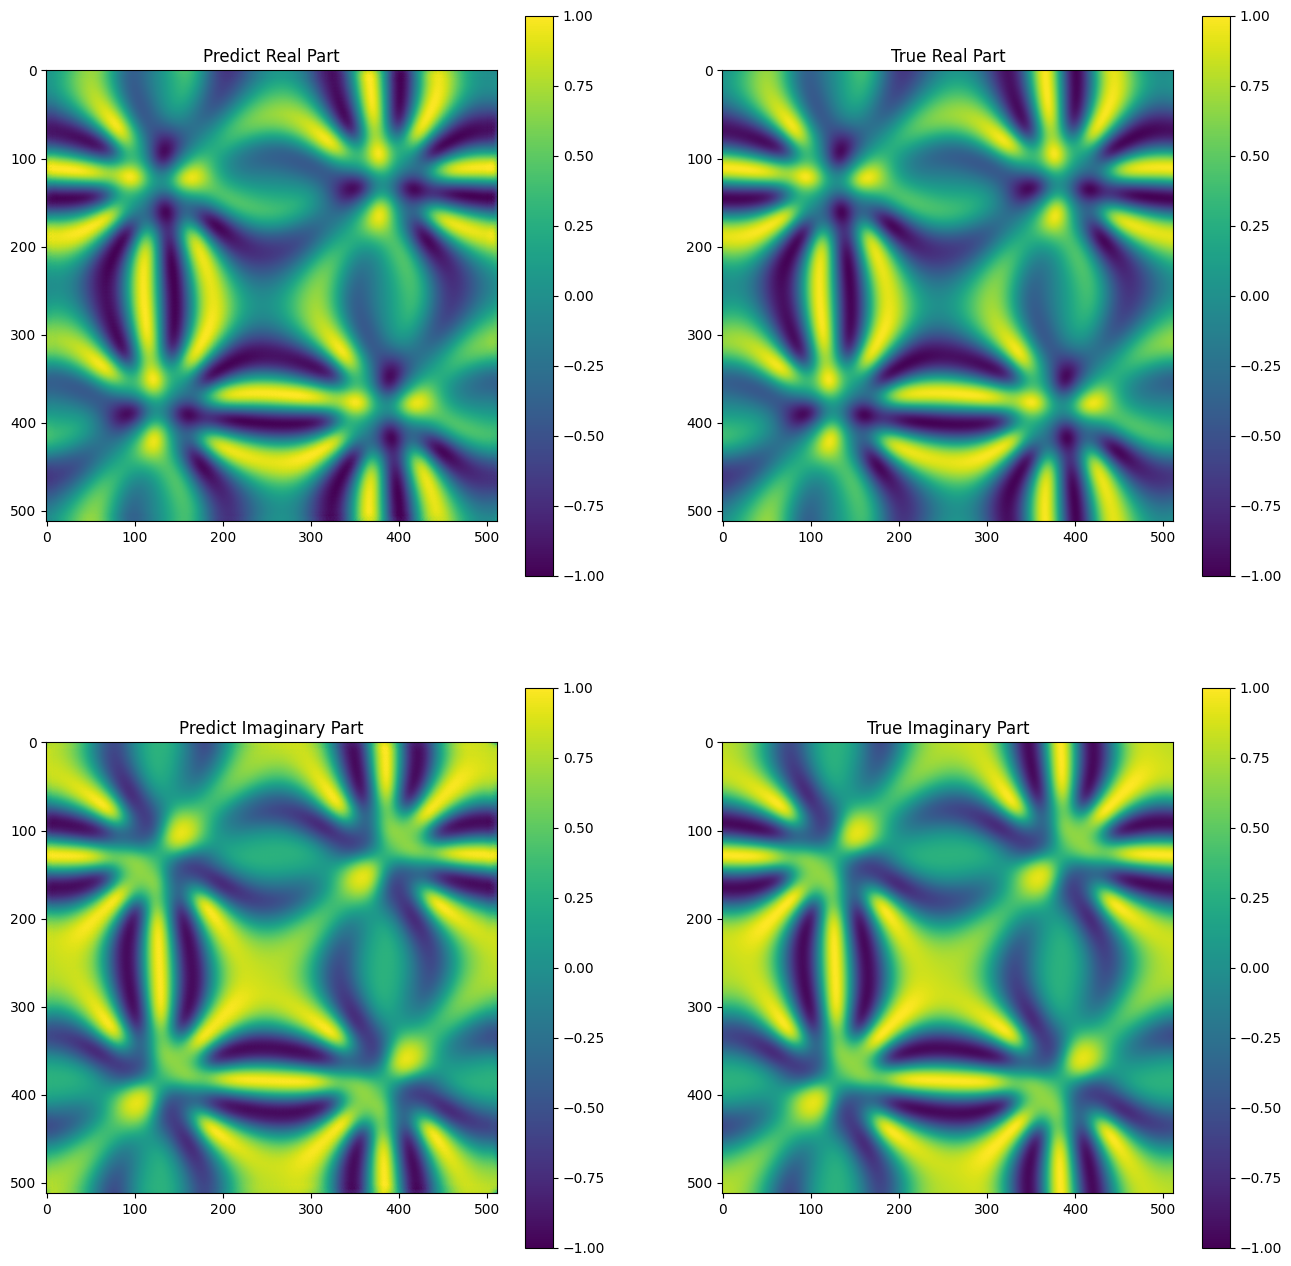

In [50]:
plt.figure(figsize=(16,16))
plt.subplot(2,2,1)
plt.imshow(psi2_real_pred,vmin=-1,vmax=1)   
plt.colorbar()
plt.title('Predict Real Part')


plt.subplot(2,2,2)
plt.imshow(psi2_real[0,0,:,:].detach().cpu().numpy(),vmin=-1,vmax=1)
plt.colorbar()
plt.title('True Real Part')


plt.subplot(2,2,3)
plt.imshow(psi2_imag_pred,vmin=-1,vmax=1)
plt.colorbar()
plt.title('Predict Imaginary Part')


plt.subplot(2,2,4)
plt.imshow(psi2_imag[0,0,:,:].detach().cpu().numpy(),vmin=-1,vmax=1)
plt.colorbar()
plt.title('True Imaginary Part')


plt.show()

#### 计算速度场

我们已经基于AI模型计算出了超分辨后的$\psi_1,\ \psi_2$:

预测：

`output_psi1_img`

`output_psi1_real`

`psi2_real_pred`

`psi2_imag_pred`

---

对照：

`psi1_test_real`

`psi1_test_imag`

`psi2_test_real`

`psi2_test_imag`



In [96]:
psi1_test_real = psi1_real[0,0,:,:].detach().cpu().numpy().copy()
psi1_test_imag = psi1_imag[0,0,:,:].detach().cpu().numpy().copy()

psi2_test_real = psi2_real[0,0,:,:].detach().cpu().numpy().copy()
psi2_test_imag = psi2_imag[0,0,:,:].detach().cpu().numpy().copy()

In [104]:
psi1_test_real= normalize_np(psi1_test_real)
psi1_test_imag= normalize_np(psi1_test_imag)
psi2_test_real= normalize_np(psi2_test_real)
psi2_test_imag= normalize_np(psi2_test_imag)

In [105]:

psi1_test = psi1_test_real + 1j * psi1_test_imag
psi2_test = psi2_test_real + 1j * psi2_test_imag

psi_test_combined = np.stack((psi1_test, psi2_test), axis=-1)

In [106]:
psi1_pred = output_psi1_real + 1j * output_psi1_img
psi2_pred = psi2_real_pred + 1j * psi2_imag_pred


psi_combined = np.stack((psi1_pred, psi2_pred), axis=-1)


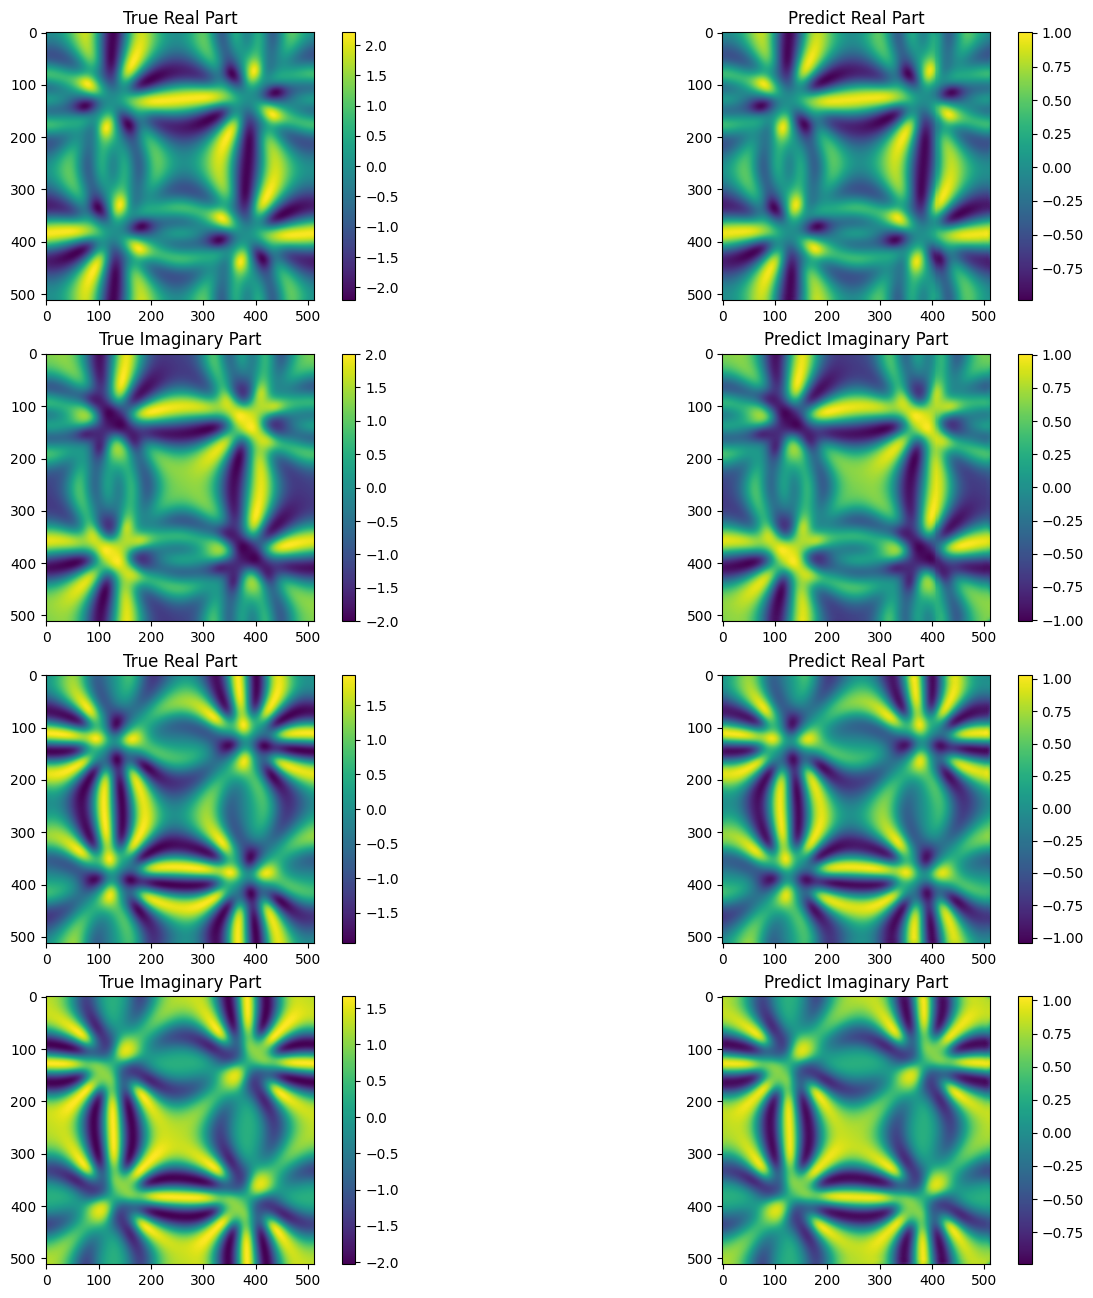

In [107]:
plt.figure(figsize=(16,16))
plt.subplot(4,2,1)
plt.imshow(normalize_np(psi1_test_real))
plt.colorbar()
plt.title('True Real Part')

plt.subplot(4,2,2)
plt.imshow(output_psi1_real)
plt.colorbar()
plt.title('Predict Real Part')

plt.subplot(4,2,3)
plt.imshow(psi1_test_imag)
plt.colorbar()
plt.title('True Imaginary Part')

plt.subplot(4,2,4)
plt.imshow(output_psi1_img)
plt.colorbar()
plt.title('Predict Imaginary Part')

plt.subplot(4,2,5)
plt.imshow(psi2_test_real)
plt.colorbar()
plt.title('True Real Part')

plt.subplot(4,2,6)
plt.imshow(psi2_real_pred)
plt.colorbar()
plt.title('Predict Real Part')

plt.subplot(4,2,7)
plt.imshow(psi2_test_imag)
plt.colorbar()
plt.title('True Imaginary Part')

plt.subplot(4,2,8)
plt.imshow(psi2_imag_pred)
plt.colorbar()
plt.title('Predict Imaginary Part')

plt.show()

In [47]:
resx, resy = psi_combined.shape[0], psi_combined.shape[1]
hbar = 1.0  # 这里假设 hbar = 1
Npsi = psi_combined.shape[-1]

In [80]:

velocity_calculator = VelocityFieldCalculator(resx, resy, hbar, Npsi)

vx_pre, vy_pre = velocity_calculator.VelocityOneForm(psi_combined)
vx_test, vy_test = velocity_calculator.VelocityOneForm(psi_test_combined)

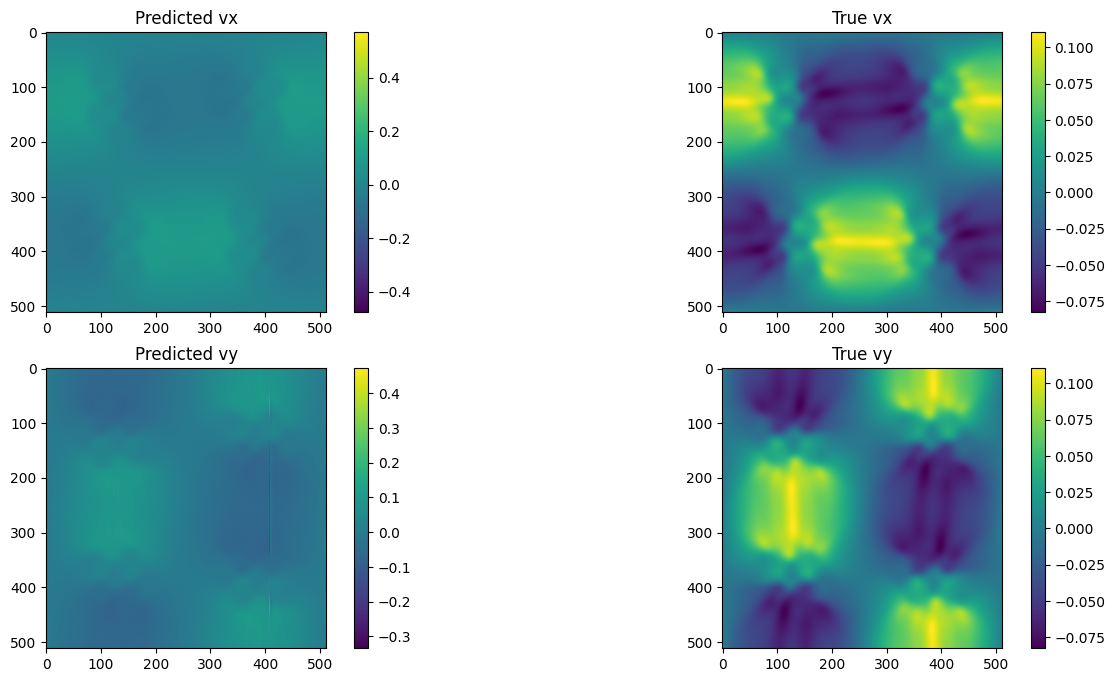

In [103]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.imshow(vx_pre)
plt.colorbar()
plt.title('Predicted vx')

plt.subplot(2,2,2)
plt.imshow(vx_test)
plt.colorbar()
plt.title('True vx')

plt.subplot(2,2,3)
plt.imshow(vy_pre)
plt.colorbar()
plt.title('Predicted vy')

plt.subplot(2,2,4)
plt.imshow(vy_test)
plt.colorbar()
plt.title('True vy')

plt.show()



### 使用迁移学习进行训练

从PyTorch的torchvision.models模块中选择一个已经在大数据集上预训练好的模型，例如ResNet或VGG。我们只会使用模型的前几层来提取特征，不使用它的最后一层（通常用于分类任务）。

Using device: cuda


c:\Users\user\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20000, Loss: 2290.91162109375
Epoch 2/20000, Loss: 2290.833251953125
Epoch 3/20000, Loss: 2290.75439453125
Epoch 4/20000, Loss: 2290.676025390625
Epoch 5/20000, Loss: 2290.599853515625
Epoch 6/20000, Loss: 2290.52197265625
Epoch 7/20000, Loss: 2290.444091796875
Epoch 8/20000, Loss: 2290.36767578125
Epoch 9/20000, Loss: 2290.290283203125
Epoch 10/20000, Loss: 2290.213623046875
Epoch 11/20000, Loss: 2290.138671875
Epoch 12/20000, Loss: 2290.0615234375
Epoch 13/20000, Loss: 2289.984130859375
Epoch 14/20000, Loss: 2289.907470703125
Epoch 15/20000, Loss: 2289.83056640625
Epoch 16/20000, Loss: 2289.75341796875
Epoch 17/20000, Loss: 2289.677001953125
Epoch 18/20000, Loss: 2289.5986328125
Epoch 19/20000, Loss: 2289.520751953125
Epoch 20/20000, Loss: 2289.442138671875
Epoch 21/20000, Loss: 2289.363037109375
Epoch 22/20000, Loss: 2289.283935546875
Epoch 23/20000, Loss: 2289.204833984375
Epoch 24/20000, Loss: 2289.124267578125
Epoch 25/20000, Loss: 2289.04345703125
Epoch 26/20000, Loss: 2

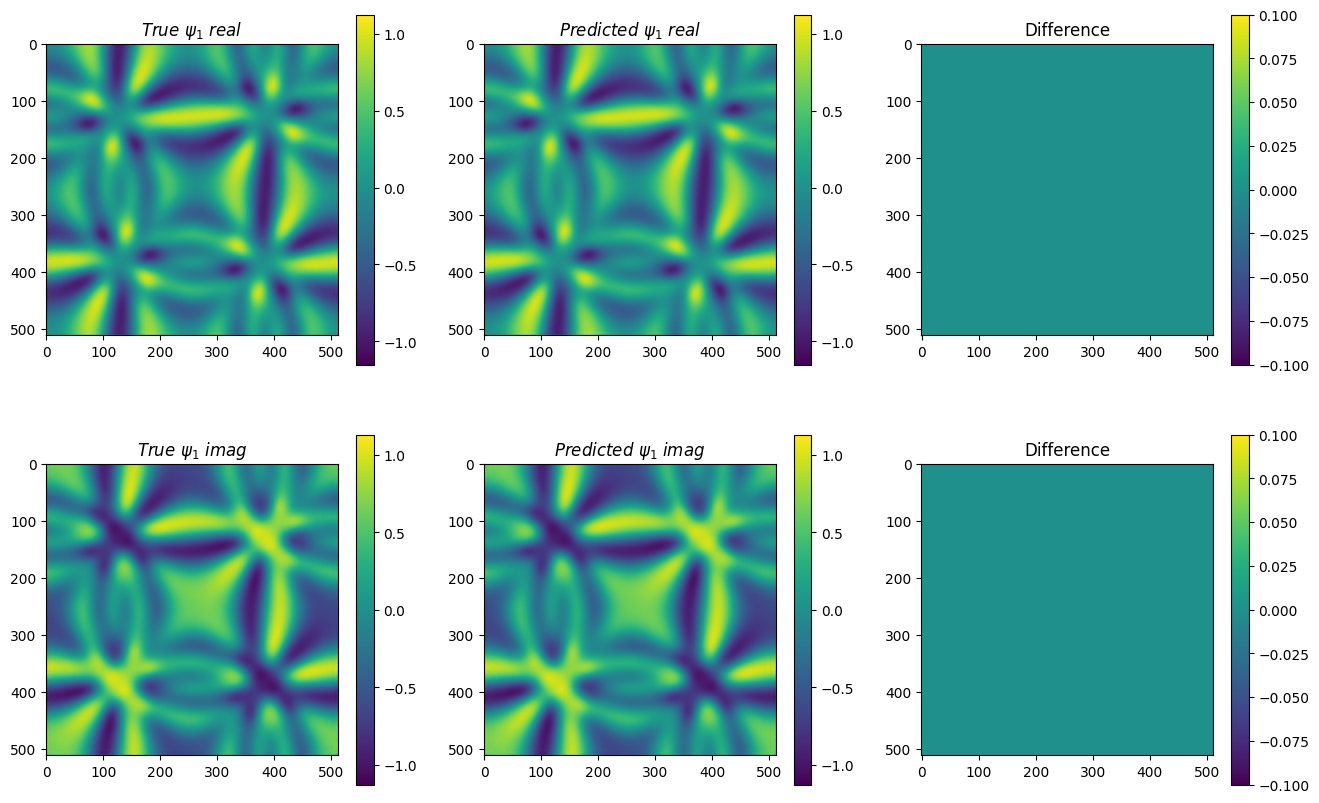

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import scipy.io as sio
import matplotlib.pyplot as plt

# 使用GPU或CPU设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# 加载预训练的ResNet18模型
pretrained_model = models.resnet18(pretrained=True)

# 移除最后的分类层，保留到倒数第二层
pretrained_model = nn.Sequential(*list(pretrained_model.children())[:-2])

# 冻结预训练模型的参数
for param in pretrained_model.parameters():
    param.requires_grad = False

# 自定义超分辨率模型
class SuperResolutionModel(nn.Module):
    def __init__(self, pretrained_model):
        super(SuperResolutionModel, self).__init__()
        self.features = pretrained_model
        self.upconv1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.relu1 = nn.ReLU()
        self.upconv2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.relu2 = nn.ReLU()
        self.upconv3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.relu3 = nn.ReLU()
        self.upconv4 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.relu4 = nn.ReLU()
        self.upconv5 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1)
        self.relu5 = nn.ReLU()
        self.upconv6 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=4, stride=2, padding=1)
        self.relu6 = nn.ReLU()
        self.upconv7 = nn.ConvTranspose2d(in_channels=8, out_channels=2, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.features(x)
        x = self.relu1(self.upconv1(x))
        x = self.relu2(self.upconv2(x))
        x = self.relu3(self.upconv3(x))
        x = self.relu4(self.upconv4(x))
        x = self.relu5(self.upconv5(x))
        x = self.relu6(self.upconv6(x))
        x = self.upconv7(x)
        return x


# 实例化模型
model = SuperResolutionModel(pretrained_model).to(device)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# 读取数据
velocity_data = sio.loadmat('D:/zjPhD/Programzj/psiToU/Ginzburg_Lan/Clebsch_flowfield/data/High_Resolution/train/velocity_field.mat')
ux0 = torch.tensor(velocity_data['ux'], dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1, 1, 512, 512)
uy0 = torch.tensor(velocity_data['uy'], dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1, 1, 512, 512)

wave_function_data = sio.loadmat('D:/zjPhD/Programzj/psiToU/Ginzburg_Lan/Clebsch_flowfield/data/High_Resolution/train/wave_function.mat')
psi1_0 = torch.tensor(wave_function_data['psi1'], dtype=torch.complex64)
psi2_0 = torch.tensor(wave_function_data['psi2'], dtype=torch.complex64)

# 分别提取实部和虚部，并添加通道维度
psi1_real = psi1_0.real.unsqueeze(0).unsqueeze(0)  # (1, 1, 512, 512)
psi1_imag = psi1_0.imag.unsqueeze(0).unsqueeze(0)  # (1, 1, 512, 512)
psi2_real = psi2_0.real.unsqueeze(0).unsqueeze(0)  # (1, 1, 512, 512)
psi2_imag = psi2_0.imag.unsqueeze(0).unsqueeze(0)  # (1, 1, 512, 512)

# 下采样函数
def downsample(psi1_real, psi1_imag, psi2_real, psi2_imag):
    downsample = nn.AvgPool2d(kernel_size=4, stride=4)
    psi1_real_low_res = downsample(psi1_real)
    psi1_imag_low_res = downsample(psi1_imag)
    psi2_real_low_res = downsample(psi2_real)
    psi2_imag_low_res = downsample(psi2_imag)
    low_res_input = torch.cat([psi1_real_low_res, psi1_imag_low_res], dim=1)
    return low_res_input

# 使用下采样生成低分辨率输入
low_res_input = downsample(psi1_real, psi1_imag, psi2_real, psi2_imag)

# 将输入扩展到3个通道
low_res_input_3ch = torch.cat([low_res_input, low_res_input[:, :1, :, :]], dim=1)

# 训练和验证循环
epochs = 20000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # 将输入传递给模型
    output = model(low_res_input_3ch.to(device))

    # 计算损失
    target = torch.cat([psi1_real, psi1_imag], dim=1).to(device)

    loss = 10000 * criterion(output, target)

    # 反向传播和优化
    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# 可视化结果
plt.figure(figsize=(16,10))
plt.subplot(2,3,1)
plt.imshow(output[0,0,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('$True\ \psi_1\ real$')

plt.subplot(2,3,2)
plt.imshow(output[0,0,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('$Predicted\ \psi_1\ real$')

plt.subplot(2,3,3)
plt.imshow(output[0,0,:,:].detach().cpu().numpy() - output[0,0,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('Difference')

plt.subplot(2,3,4)
plt.imshow(output[0,1,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('$True\ \psi_1\ imag$')

plt.subplot(2,3,5)
plt.imshow(output[0,1,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('$Predicted\ \psi_1\ imag$')

plt.subplot(2,3,6)
plt.imshow(output[0,1,:,:].detach().cpu().numpy() - output[0,1,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('Difference')

plt.show()


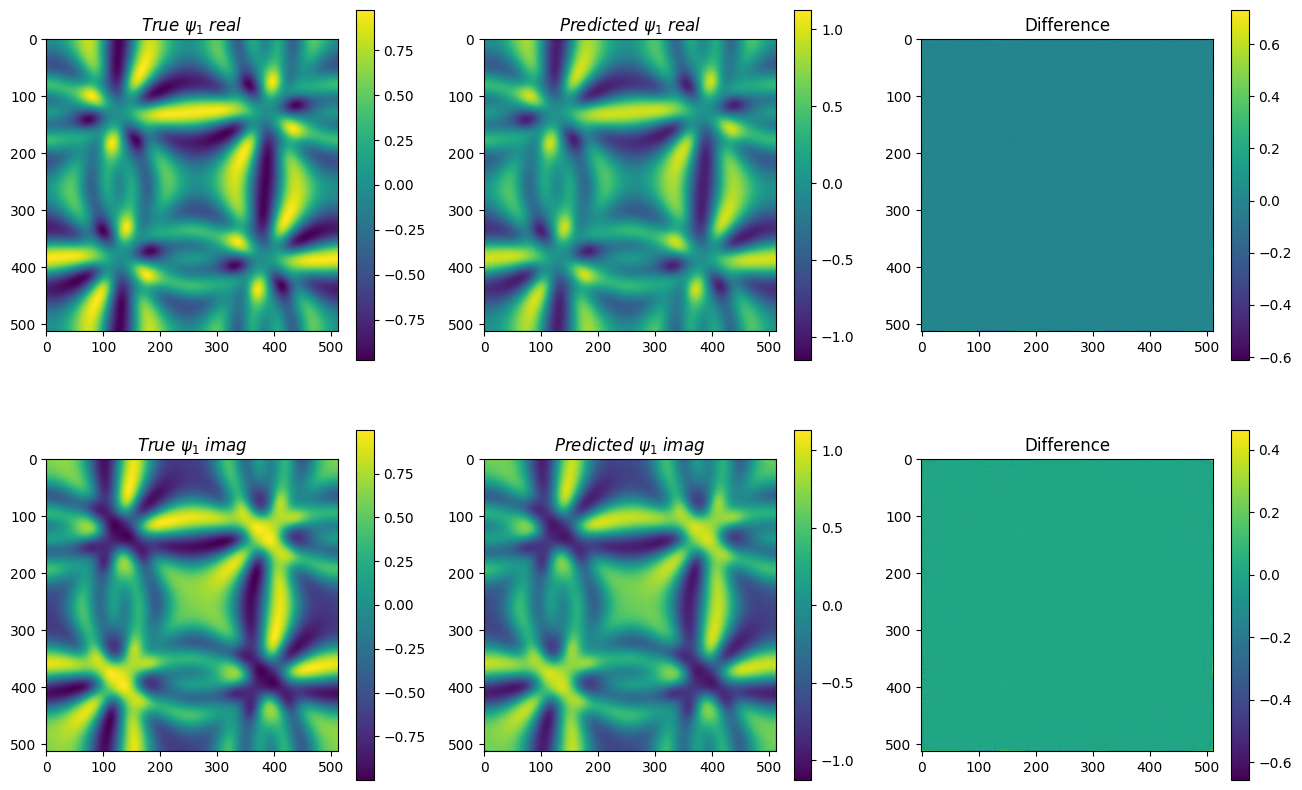

In [4]:

plt.figure(figsize=(16,10))
plt.subplot(2,3,1)
plt.imshow(target[0,0,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('$True\ \psi_1\ real$')

plt.subplot(2,3,2)
plt.imshow(output[0,0,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('$Predicted\ \psi_1\ real$')

plt.subplot(2,3,3)
plt.imshow(target[0,0,:,:].detach().cpu().numpy() - output[0,0,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('Difference')

plt.subplot(2,3,4)
plt.imshow(target[0,1,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('$True\ \psi_1\ imag$')

plt.subplot(2,3,5)
plt.imshow(output[0,1,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('$Predicted\ \psi_1\ imag$')

plt.subplot(2,3,6)
plt.imshow(target[0,1,:,:].detach().cpu().numpy() - output[0,1,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('Difference')

plt.show()


In [5]:
output.shape

torch.Size([1, 2, 512, 512])

#### 随机生成一组数据进行测试

In [31]:
import numpy as np
import torch

# 生成波函数的函数
def generate_wave_function(nx, ny, kx=1.0, ky=1.0, phase_shift=0.0):
    x = np.linspace(-np.pi, np.pi, nx)
    y = np.linspace(-np.pi, np.pi, ny)
    px, py = np.meshgrid(x, y)
    
    # 使用简单的平面波函数作为示例
    real_part = np.cos(kx * px + ky * py + phase_shift)
    imag_part = np.sin(kx * px + ky * py + phase_shift)
    
    wave_function = real_part + 1j * imag_part
    return wave_function

# 通过波函数生成速度场
def generate_velocity_field_from_wave_function(psi, hbar=0.1):
    psi_x = np.gradient(psi.real, axis=0) + 1j * np.gradient(psi.imag, axis=0)
    psi_y = np.gradient(psi.real, axis=1) + 1j * np.gradient(psi.imag, axis=1)
    
    vx = -hbar * psi.imag * psi_x.real + hbar * psi.real * psi_x.imag
    vy = -hbar * psi.imag * psi_y.real + hbar * psi.real * psi_y.imag
    
    return vx, vy

# 生成随机测试数据集
def generate_physical_test_data(nx=512, ny=512, kx=1.0, ky=1.0, hbar=0.1):
    # 生成波函数
    psi1 = generate_wave_function(nx, ny, kx=kx, ky=ky)
    psi2 = generate_wave_function(nx, ny, kx=kx, ky=ky, phase_shift=np.pi/4)  # 第二个波函数有一个相位偏移

    # 通过波函数生成速度场
    vx, vy = generate_velocity_field_from_wave_function(psi1 + psi2, hbar=hbar)
    
    # 转换为 PyTorch 张量
    test_data = {
        'ux': torch.tensor(vx, dtype=torch.float32).unsqueeze(0).unsqueeze(0),
        'uy': torch.tensor(vy, dtype=torch.float32).unsqueeze(0).unsqueeze(0),
        'psi1': torch.tensor(psi1, dtype=torch.complex64),
        'psi2': torch.tensor(psi2, dtype=torch.complex64)
    }
    
    return test_data

# 生成测试数据
test_data = generate_physical_test_data()

# 检查生成的数据形状
print(f"ux shape: {test_data['ux'].shape}")
print(f"uy shape: {test_data['uy'].shape}")
print(f"psi1 shape: {test_data['psi1'].shape}")
print(f"psi2 shape: {test_data['psi2'].shape}")


ux shape: torch.Size([1, 1, 512, 512])
uy shape: torch.Size([1, 1, 512, 512])
psi1 shape: torch.Size([512, 512])
psi2 shape: torch.Size([512, 512])


Testing Loss: 0.00017708077211864293


Text(0.5, 1.0, 'Difference')

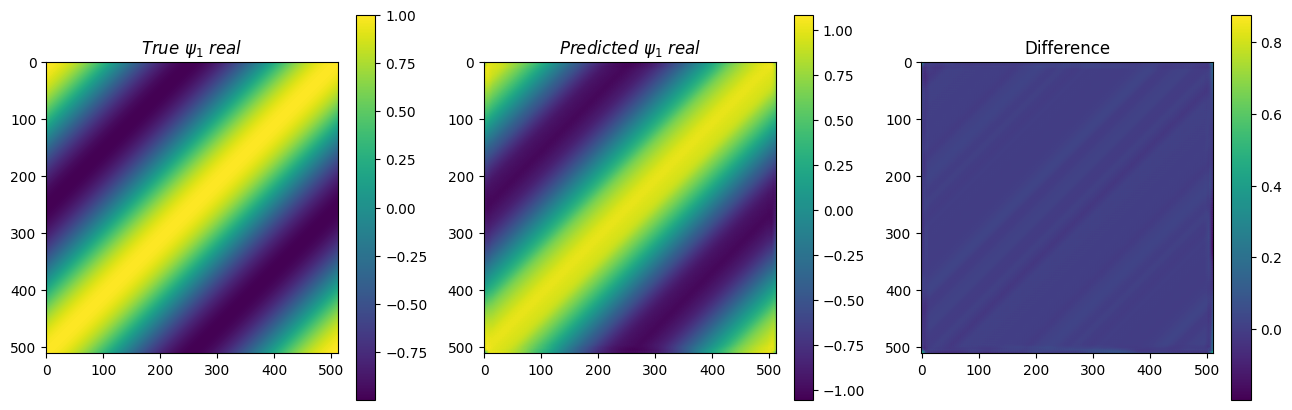

In [32]:
# 处理为模型输入的形式
test_ux = test_data['ux']
test_uy = test_data['uy']
test_psi1 = test_data['psi1']
test_psi2 = test_data['psi2']

test_psi1_real = test_psi1.real.unsqueeze(0).unsqueeze(0)
test_psi1_imag = test_psi1.imag.unsqueeze(0).unsqueeze(0)
test_psi2_real = test_psi2.real.unsqueeze(0).unsqueeze(0)
test_psi2_imag = test_psi2.imag.unsqueeze(0).unsqueeze(0)

# 下采样处理
test_low_res_input = downsample(test_ux, test_uy, test_psi1_real, test_psi1_imag, test_psi2_real, test_psi2_imag)

# 将数据传递给模型进行预测
model.eval()  # 设置模型为评估模式
with torch.no_grad():
    output_test = model(test_low_res_input.to(device))

# 真实值
target_test = torch.cat([test_psi1_real, test_psi1_imag], dim=1).to(device)

# 计算测试损失
loss_test = criterion(output_test, target_test)
print(f'Testing Loss: {loss_test.item()}')

# 可视化测试结果
import matplotlib.pyplot as plt

plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
plt.imshow(target_test[0,0,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('$True\ \psi_1\ real$')

plt.subplot(1,3,2)
plt.imshow(output_test[0,0,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('$Predicted\ \psi_1\ real$')

plt.subplot(1,3,3)
plt.imshow(target_test[0,0,:,:].detach().cpu().numpy() - output_test[0,0,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('Difference')


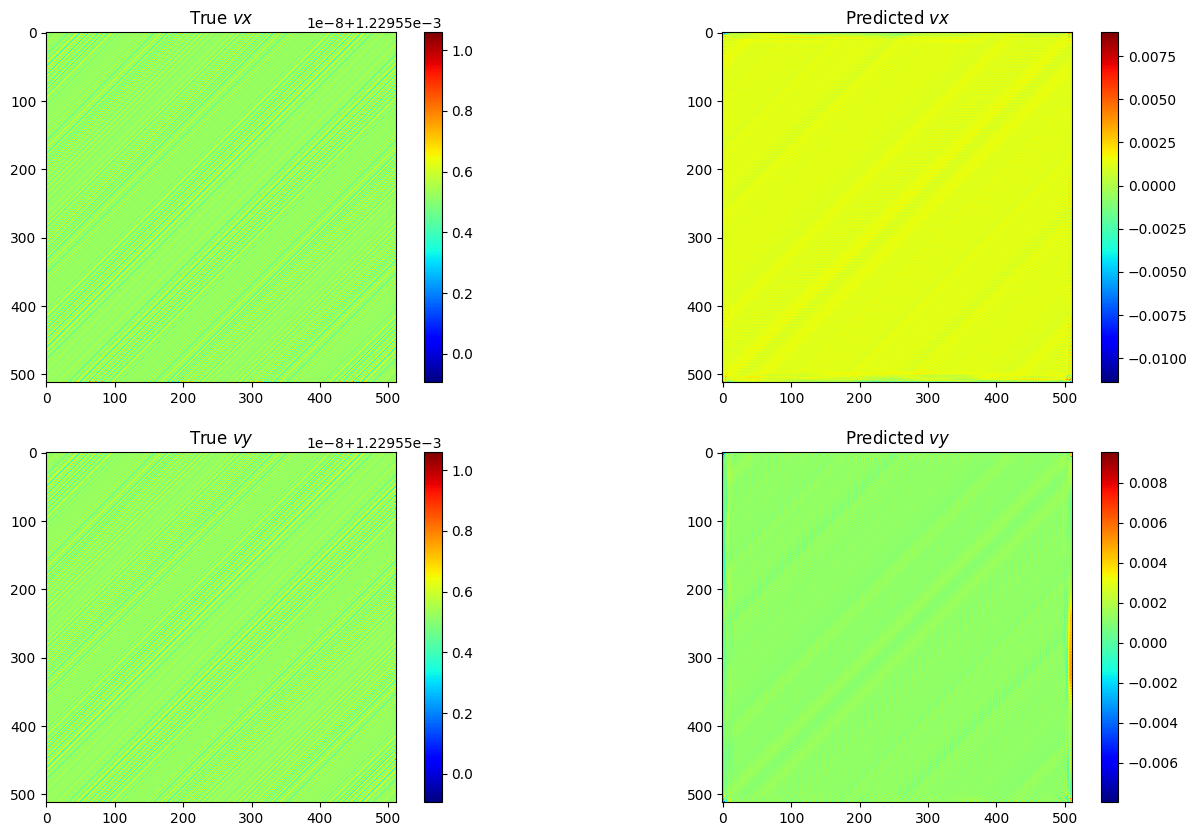

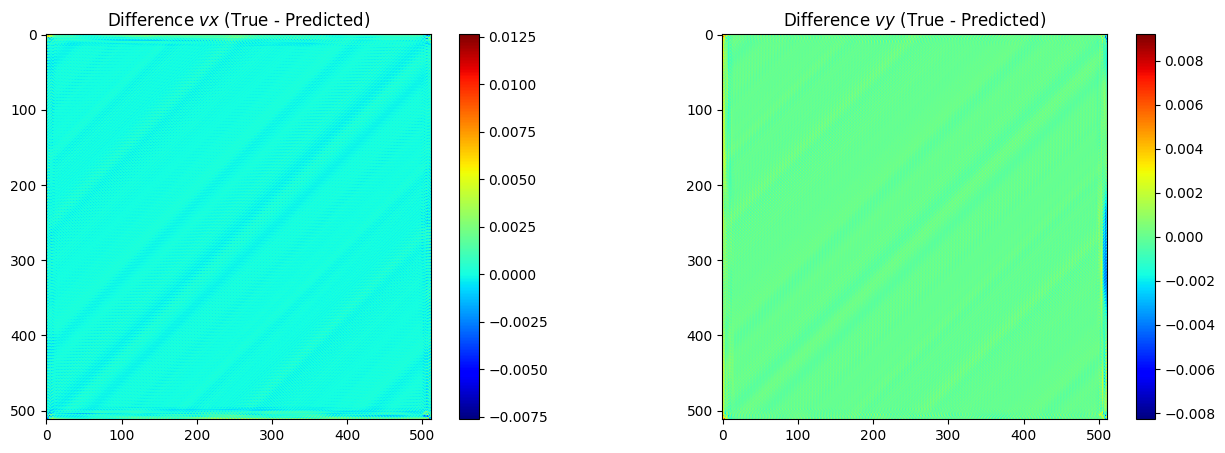

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# 定义速度场计算函数
def calculate_velocity_from_psi(psi, hbar=0.1):
    psi_x = np.gradient(psi.real, axis=0) + 1j * np.gradient(psi.imag, axis=0)
    psi_y = np.gradient(psi.real, axis=1) + 1j * np.gradient(psi.imag, axis=1)
    
    vx = -hbar * (psi.imag * psi_x.real - psi.real * psi_x.imag)
    vy = -hbar * (psi.imag * psi_y.real - psi.real * psi_y.imag)
    
    return vx, vy

# 从模型输出中提取预测的 psi1_real 和 psi1_imag
psi1_real_pred = output_test[0, 0, :, :].detach().cpu().numpy()
psi1_imag_pred = output_test[0, 1, :, :].detach().cpu().numpy()
psi1_pred = psi1_real_pred + 1j * psi1_imag_pred

# 计算预测的速度场
vx_pred, vy_pred = calculate_velocity_from_psi(psi1_pred)

# 从真实数据中提取 psi1_real 和 psi1_imag
psi1_real_true = target_test[0, 0, :, :].detach().cpu().numpy()
psi1_imag_true = target_test[0, 1, :, :].detach().cpu().numpy()
psi1_true = psi1_real_true + 1j * psi1_imag_true

# 计算真实的速度场
vx_true, vy_true = calculate_velocity_from_psi(psi1_true)

# 可视化对比
plt.figure(figsize=(16, 10))

# 真实的 vx
plt.subplot(2, 2, 1)
plt.imshow(vx_true, cmap='jet')
plt.colorbar()
plt.title('True $vx$')

# 预测的 vx
plt.subplot(2, 2, 2)
plt.imshow(vx_pred, cmap='jet')
plt.colorbar()
plt.title('Predicted $vx$')

# 真实的 vy
plt.subplot(2, 2, 3)
plt.imshow(vy_true, cmap='jet')
plt.colorbar()
plt.title('True $vy$')

# 预测的 vy
plt.subplot(2, 2, 4)
plt.imshow(vy_pred, cmap='jet')
plt.colorbar()
plt.title('Predicted $vy$')

plt.show()

# 可视化速度场的误差
plt.figure(figsize=(16, 5))

# vx 误差
plt.subplot(1, 2, 1)
plt.imshow(vx_true - vx_pred, cmap='jet')
plt.colorbar()
plt.title('Difference $vx$ (True - Predicted)')

# vy 误差
plt.subplot(1, 2, 2)
plt.imshow(vy_true - vy_pred, cmap='jet')
plt.colorbar()
plt.title('Difference $vy$ (True - Predicted)')

plt.show()


### 误差场超分辨